Необходимые модули:

Необходимые модули:


In [6]:
import calendar
import pandas as pd
import os
# os.chdir('C:\\Users\\Nikita\\Desktop')
from scipy import stats
import statsmodels.api as sm
import numpy as np
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return (np.exp(np.log(lmbda*y+1)/lmbda))

Визуальный анализ ряда, проверка на стационарность:

Критерий Дики-Фуллера: p=0.991850


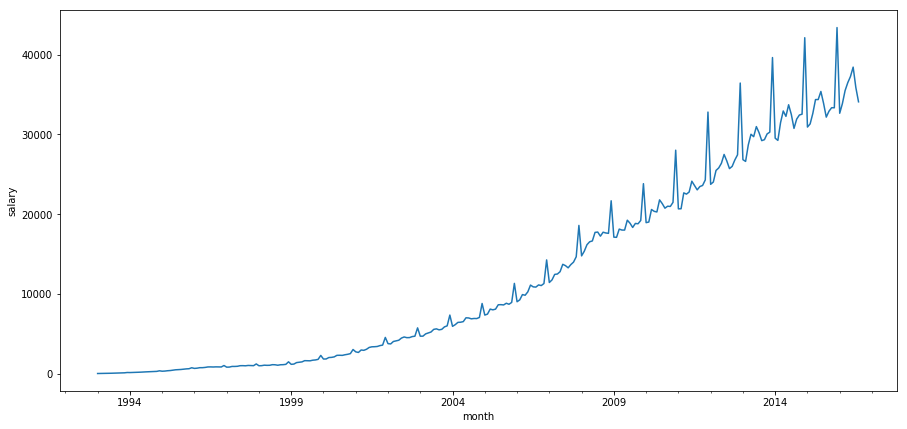

<Figure size 1080x720 with 0 Axes>

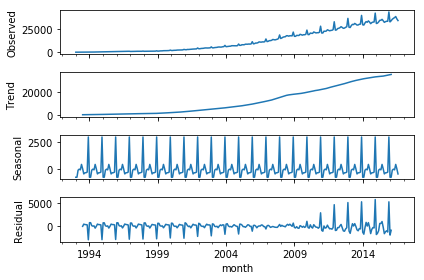

In [8]:
salary = pd.read_csv('WAG_C_M.csv', ';', index_col = ['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize = (15,7))
salary.WAG_C_M.plot()
plt.ylabel('salary')

plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Преобразования с целью уменьшения дисперсии при помощи метода Бокса-Кокса и дифференцирования:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899
Критерий Дики-Фуллера: p=0.014697
Критерий Дики-Фуллера: p=0.000000


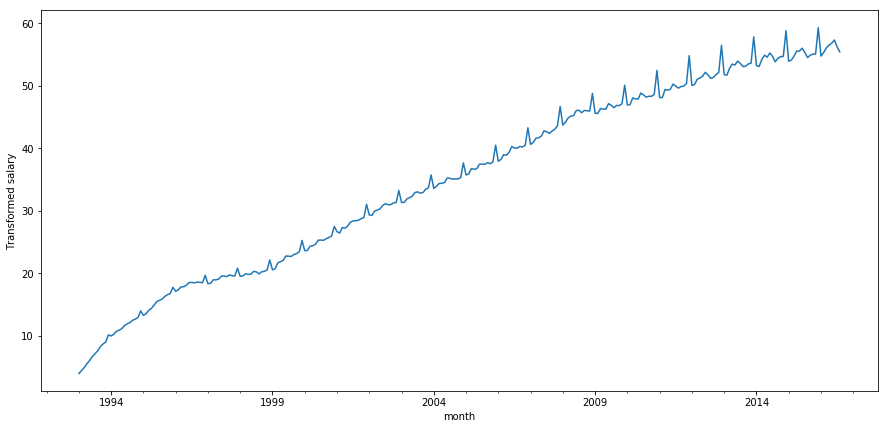

<Figure size 1080x720 with 0 Axes>

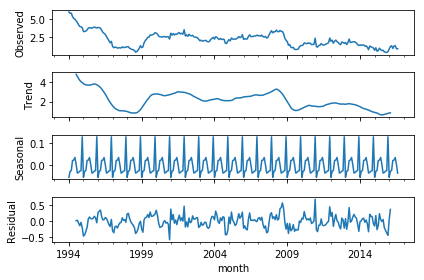

<Figure size 1080x720 with 0 Axes>

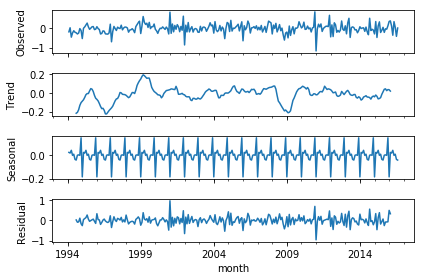

In [9]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize = (15,7))
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff[12:])[1])

salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2[13:])[1])

Выбор начальных приближений для параметров модели при помощи графиков автокорреляции и частичной автокорреляции:

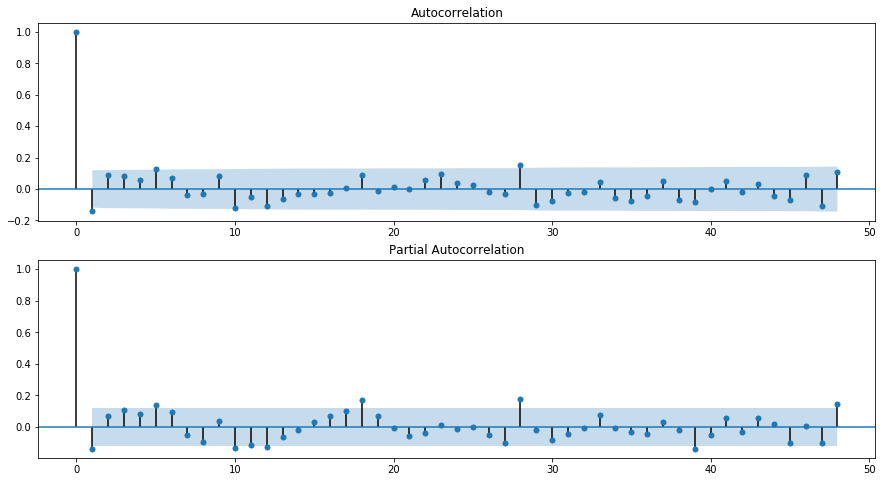

In [10]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)

ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

Построение модели:

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

80
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
      parameters        aic
32  (2, 3, 0, 0) -21.091372
34  (2, 3, 1, 0) -20.398611
33  (2, 3, 0, 1) -20.140421
35  (2, 3, 1, 1) -19.568936
46  (3, 3, 1, 0) -18.637842
                                 Statespace Model Results                                 
Dep. Variable:    

Оценка результов моделии и визуализация:

Критерий Стьюдента: p=0.230091
Критерий Дики-Фуллера: p=0.000000


Text(0,0.5,'salary WAG_C_M')

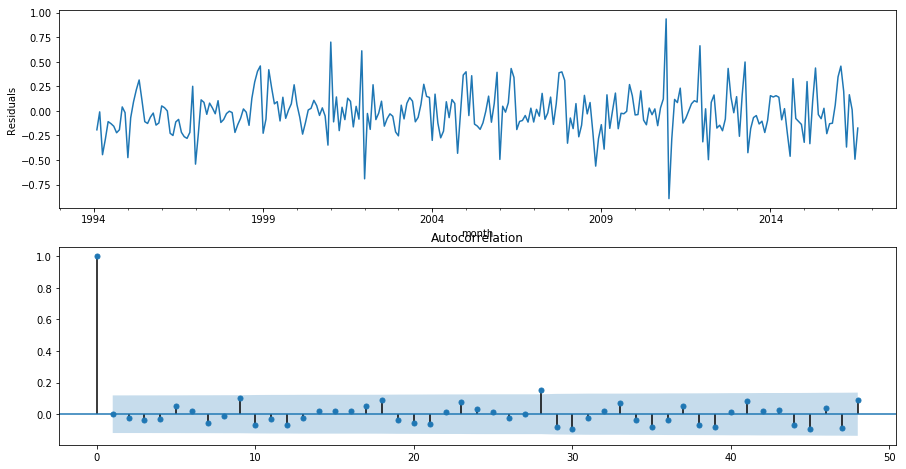

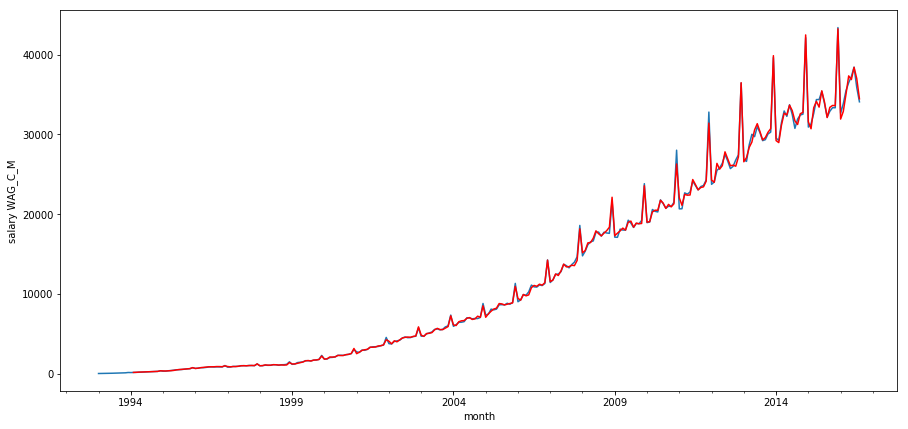

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('salary WAG_C_M')

Построение прогноза:

Text(0,0.5,'salary WAG_C_M')

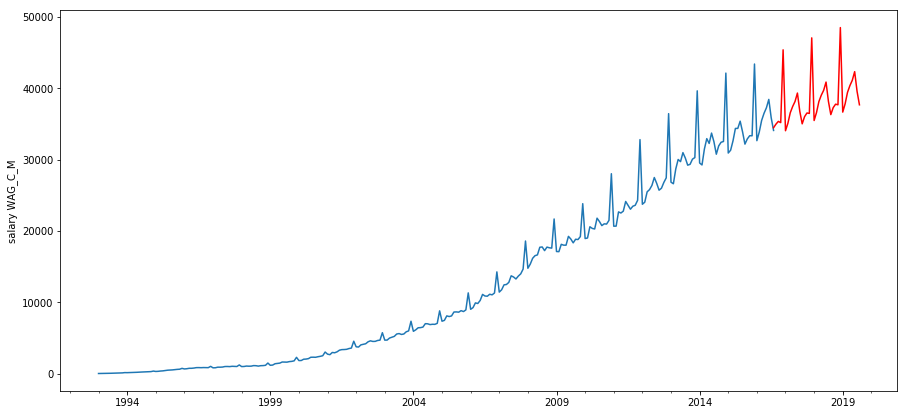

In [13]:
salary2 = salary[['WAG_C_M']]
date_list = [calendar.datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=319), lmbda)

plt.figure(figsize=(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('salary WAG_C_M')